In [1]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap, pmap, random

# Datatypes and Naming Conventions

### Type Synonyms

In [2]:
from typing import Any
from typing import FrozenSet
from typing import List
import numpy.typing as npt

UserId = str
UserIdSet = FrozenSet[UserId]

Corpus = str
Token = str
Tokens = List[Token]
UniqueTokens = FrozenSet[Token]

Edge = Any
Edges = FrozenSet[Edge]

Graph = Any
EdgeWeight = int

Vec = any
VecInt = npt.NDArray[np.int_]
WordVec = VecInt

TwitterData = Any
TwitterDataP = Any

TokenCount = Any


UserCorpusMap = Any
UserTokensMap = Any
UserTokenCountMap = Any
UserWordVecMap = Any
Set = Any
IndexMap = Any
WordVecIndex   = IndexMap
EdgeVecIndex = IndexMap



```
TwitterDataP = 
            [
              {
                user: UserId,
                corpus: Tokens,
                followers: [ UserId ],
                followings: [ UserId ]
              }
            ]

Edge = frozenset(UserId, UserId)
Graph = Map<Edge, EdgeWeight>

TokenCount = Map<Token, Int>

UserCorpusMap = Map<UserId, Corpus>
UserTokensMap = Map<UserId, Tokens>
UserTokenCountMap = Map<UserId, TokenCount>
UserWordVecMap = Map<UserId, WordVec>

WordVecIndex = Map<Token, Integer>
EdgeVecIndex = Map<Edge, Integer>

IndexMap = Map<T, Integer>
```



# Functions

## User Extraction from Data

In [236]:
def createUserTokensMap(data : TwitterDataP) -> UserTokensMap:
  userTokensMap = {}
  for user in data:
    userTokensMap[user['user']] = user['corpus']
  return userTokensMap

def getUserIdSet(userCorpusMap : UserCorpusMap) -> UserIdSet:
  return frozenset(userCorpusMap.keys())

## Graph Construction

In [237]:
from itertools import combinations

def mkEdge(u1 : UserId, u2 : UserId) -> Edge:
  return frozenset({u1,u2})

def createEdges(userIdSet : UserIdSet) -> Edges:
  edges = set({})
  for (a,b) in combinations(userIdSet, 2):
    edges.add(mkEdge(a, b))
  return edges

def graphSet(edges : Edges, val : int) -> Graph:
  graph = {}
  for e in edges:
    graph[e] = val
  return graph

def graphZeroed(edges : Edges) -> Graph:
  return graphSet(edges, 0)

def graphMergeGroundTruth(graph: Graph, data : TwitterDataP) -> Graph:
  mergedGraph = graph.copy()
  for d in data:
    followed = set(d['followers'])
    following = set(d['followings'])
    u1 = d['user']

    for u2 in followed:
      mergedGraph[mkEdge(u1, u2)] = 0.5
    for u2 in following:
      mergedGraph[mkEdge(u1, u2)] = 0.5

    twoWay = followed.intersection(following)
    for u2 in twoWay:
      mergedGraph[mkEdge(u1, u2)] = 1.0

  return mergedGraph

def graphCos(edges: Edges, userWordVecMap : UserWordVecMap) -> Graph:
  graph = {}
  for u1, u2 in edges:
    v = cos(userWordVecMap[u1], userWordVecMap[u2])
    graph[mkEdge(u1,u2)] = v
  return graph

def createEdgeVecIndex(edges: Edges) -> EdgeVecIndex:
  return createWordVecIndex(edges)

def graphEdgeVec(graph : Graph, edgeVecIndex : EdgeVecIndex):
  return tokenCountWordVec(graph, edgeVecIndex)

## Corpus Processing and Transformations

In [238]:
from nltk import word_tokenize

In [239]:
def countTokens(tokens : Tokens) -> TokenCount:
  tokenCount = {}
  for token in tokens:  
    tokenCount[token] = tokenCount.get(token, 0) + 1
  return tokenCount

def combineTokensList(tokens : List[Tokens]) -> Tokens:
  return sum(tokens, [])

def tokenise(corpus : Corpus) -> Tokens:
  return word_tokenize(corpus)

def leastOccuringTokens(countUpperBound : int, tokenCount : TokenCount) -> Tokens:
  leastOccuring = []
  for token, count in tokenCount.items():
    if count <= countUpperBound:
      leastOccuring.append(token)
  return leastOccuring

def excludeTokens(excludedTokens : Tokens, tokenCount : TokenCount) -> TokenCount:
  excludedCount = tokenCount.copy()
  for token in excludedTokens:
    if token in excludedCount:
      del excludedCount[token]
  return excludedCount


## WordVector


In [240]:
def createWordVecIndex(allUniqueTokens : UniqueTokens) -> WordVecIndex:
  wvIndex = {}
  for wordIndex, word in enumerate(allUniqueTokens):
    wvIndex[word] = wordIndex
  return wvIndex

def createUserWordVecMap(userTokenCountMap : UserTokenCountMap, wvIndex : WordVecIndex) -> UserWordVecMap:
    userWvMap = userTokenCountMap.copy()
    for userId, tokenCount in userTokenCountMap.items():
        userWvMap[userId] = tokenCountWordVec(tokenCount, wvIndex)
    return userWvMap

def tokenCountWordVec(tokenCount : TokenCount, wvIndex : WordVecIndex) -> WordVec:
    wordVec = np.zeros(len(wvIndex))
    for token, count in tokenCount.items():
      if token in wvIndex:
          wordIndex = wvIndex[token]
          wordVec[wordIndex] = count
    return wordVec

## Similarity Measures

In [241]:
@jit
def cos(v1 : Vec, v2 : Vec) -> float:
  return jnp.sum(v1 * v2) / (jnp.sqrt(jnp.sum(v1**2)) * (jnp.sqrt(jnp.sum(v2**2))) + 0.000001)

@jit
def cos2(v : Vec) -> float:
  #print(v.shape)
  #print(v)
  v1 = v[0]
  v2 = v[1]
  r = jnp.sum(v1 * v2) / (jnp.sqrt(jnp.sum(v1**2)) * (jnp.sqrt(jnp.sum(v2**2))) + 0.000001)
  #print(r)
  return r

def npcos2(v : Vec) -> float:
  #print(v.shape)
  #print(v)
  v1 = v[0]
  v2 = v[1]
  r = np.sum(v1 * v2) / (np.sqrt(np.sum(v1**2)) * (np.sqrt(np.sum(v2**2))) + 0.000001)
  #print(r)
  return r

def euc2(v1 : Vec, v2 : Vec) -> float:
  return jnp.sqrt(jnp.sum((v1 - v2)**2))

In [242]:
npcos2(np.array([[1, 1, 0],[0, 1 ,0]]))

0.7071062811869011

# Loading Data & Processing Data

## Loading and Counting

from google.colab import drive
drive.mount('/content/drive')

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import json
with open('./drive/MyDrive/TA/data_pre.json', 'r') as f:
  dataset = json.load(f)['dataset']
dataset[0].keys()

dict_keys(['user', 'corpus', 'followers', 'followings'])

In [12]:
userTokensMap = createUserTokensMap(dataset)
print("Users in dataset: \t", len(userTokensMap))

Users in dataset: 	 296


In [13]:
combinedTokens = combineTokensList(list(userTokensMap.values()))
print("Total token count: \t",len(combinedTokens))

totalTokenCount = countTokens(combinedTokens)
print("Unique tokens: \t \t", len(totalTokenCount.keys()))

Total token count: 	 81498
Unique tokens: 	 	 21592


In [14]:
mapToTuples = lambda x: [(k, v) for k, v in x.items()]
sortByVal   = lambda x: sorted(mapToTuples(x), reverse=True, key=lambda x: x[1])

In [15]:
print("Top 10 tokens: \t \t", sortByVal(totalTokenCount)[:10])
print("Bottom 10 tokens: \t", sortByVal(totalTokenCount)[::-1][:10])

Top 10 tokens: 	 	 [('us', 403), ('n', 332), ('ukraine', 327), ('nn', 322), ('new', 290), ('amp', 278), ('russia', 244), ('like', 223), ('one', 218), ('de', 213)]
Bottom 10 tokens: 	 [('merry', 1), ('benny', 1), ('thoses', 1), ('lap', 1), ('ruin', 1), ('angrybeaver', 1), ('mrctv', 1), ('prek', 1), ('statefunded', 1), ('dang', 1)]


## Pruning Least Occuring Tokens

In [16]:
leastOccuring3 = leastOccuringTokens(3, totalTokenCount)
print("Unique tokens that occur 3 or less times: \t", len(leastOccuring3))
print(leastOccuring3[:5])

Unique tokens that occur 3 or less times: 	 17659
['patronisi', 'pat', 'patria', 'patronis', 'ceasefire']


In [17]:
excludedCount3 = excludeTokens(leastOccuring3, totalTokenCount)
print("Unique tokens that occur more than 3 times: \t", len(excludedCount3))
print(mapToTuples(excludedCount3)[:5])

Unique tokens that occur more than 3 times: 	 3933
[('cant', 128), ('quite', 79), ('call', 171), ('misogyny', 65), ('patriarchal', 60)]


In [18]:
userTokenCountMap = userTokensMap.copy()
for user, tokens in userTokenCountMap.items():
  userTokenCountMap[user] = excludeTokens(leastOccuring3, countTokens(tokens))

In [19]:
mapToTuples(userTokenCountMap)[0]

(453998026,
 {'call': 122,
  'cant': 61,
  'face': 4,
  'misogyny': 61,
  'p': 1,
  'patriarchal': 60,
  'patronising': 56,
  'pom': 5,
  'pomp': 3,
  'pompo': 6,
  'pompou': 6,
  'pompous': 36,
  'quite': 61,
  'r': 5,
  'raab': 5})

# Constructing Graphs

### Ground Truth Graph

In [20]:
userIdSet = getUserIdSet(userTokenCountMap)
edges = createEdges(userIdSet)
graphZero = graphZeroed(edges)
graphGroundTruth = graphMergeGroundTruth(graphZero, dataset)

print("Total connections strength: \t", sum(graphGroundTruth.values()))
print("Number of edges: \t \t",len(graphGroundTruth.keys()))

Total connections strength: 	 1458.0
Number of edges: 	 	 46138


WordVec Cosine Similarity Graph

In [21]:
wvIndex = createWordVecIndex(excludedCount3.keys())
userWordVecMap = createUserWordVecMap(userTokenCountMap, wvIndex)

In [22]:
print("Unique tokens a.k.a Vector length: \t", len(wvIndex))
print("Number of users: \t \t \t", len(userWordVecMap))
print("User wv length: \t \t \t", len(list(userWordVecMap.values())[0]))

Unique tokens a.k.a Vector length: 	 3933
Number of users: 	 	 	 296
User wv length: 	 	 	 3933


In [23]:
graphCosine = graphCos(edges, userWordVecMap)

In [24]:
mapToTuples(graphCosine)[:10]

[(frozenset({3108351, 1400041982}), DeviceArray(0.18007487, dtype=float32)),
 (frozenset({45074533, 4180260695}), DeviceArray(0.01034437, dtype=float32)),
 (frozenset({4823751748, 1503701879305383937}),
  DeviceArray(0., dtype=float32)),
 (frozenset({350096077, 965947791041286144}),
  DeviceArray(0.04172273, dtype=float32)),
 (frozenset({853318165, 1071810346397122561}), DeviceArray(0., dtype=float32)),
 (frozenset({19910041, 1504164687549718529}),
  DeviceArray(0.10908907, dtype=float32)),
 (frozenset({197395180, 387283465}), DeviceArray(0.04242812, dtype=float32)),
 (frozenset({21677872, 352585204}), DeviceArray(0.06050891, dtype=float32)),
 (frozenset({340439524, 954021692426407936}),
  DeviceArray(0.12762138, dtype=float32)),
 (frozenset({14131257, 1333129975571034119}),
  DeviceArray(0.1995641, dtype=float32))]

# Analyising Data 

We have 2 datasets:
- Dataset 1 : Retrieved by traversing followers on twitter.
- Dataset 2 : Retrived by querying a topic and gathering the users.

We have already pre-processed dataset, now preprocess dataset 2.  
We also want to learn about each of the datasets. 
We can first investigate the links:
- Looking at total number of users in each dataset.
- Counting the percentage of edges which are 0.5 strength on the ground truth graph.
- Counting the percentage of edges which are 1 strength on the ground truth graph.

We can also investigate the text content of the whole corpus:
- How many unique tokens are there in each dataset?
- What is the mean and variance of the number of unique tokens for a single user in each dataset?
- What is the distribution of the tokens for the each dataset?

Yash has plotted the plot of token occurance for dataset 1, do the same for dataset 2.


### Links in Each Dataset

In [25]:
numberOfUsersDataset1 = len(userTokenCountMap)
print(numberOfUsersDataset1)
# repeat for dataset 2

296


In [26]:
print(mapToTuples(graphGroundTruth)[:5])

[(frozenset({1400041982, 3108351}), 0), (frozenset({45074533, 4180260695}), 0), (frozenset({1503701879305383937, 4823751748}), 0), (frozenset({965947791041286144, 350096077}), 0), (frozenset({1071810346397122561, 853318165}), 0)]


In [27]:
def countValOccurance(vals, val):
  count = 0
  for v in vals:
    if val == v:
      count += 1
  return count

totalEdges = len(graphGroundTruth)
print(totalEdges)
halfLinkCount = countValOccurance(graphGroundTruth.values(), 0.5)
fullLinkCount = countValOccurance(graphGroundTruth.values(), 1)
print(halfLinkCount/totalEdges)
print(fullLinkCount/totalEdges)

# repeat for dataset 2

46138
0.05743638649269583
0.0028826563786900168


### Text Content of Dataset

In [28]:
# can use userTokenCountMap and excludedCount3/
print(mapToTuples(userTokenCountMap)[0]) # is a map from user to token count for that user
# excludedCount3 has all the tokens counted, except maybe do it for full token list (see the code above that constructs this variable)

(453998026, {'cant': 61, 'quite': 61, 'call': 122, 'misogyny': 61, 'patriarchal': 60, 'patronising': 56, 'pompous': 36, 'pomp': 3, 'pompou': 6, 'r': 5, 'pom': 5, 'pompo': 6, 'raab': 5, 'face': 4, 'p': 1})


# Comparing Graphs with Similarity Measures

In [29]:
edgeVecIndex = createEdgeVecIndex(edges)
cosineEv = graphEdgeVec(graphCosine, edgeVecIndex)
groundTruthEv = graphEdgeVec(graphGroundTruth, edgeVecIndex)
zeroedEv = graphEdgeVec(graphZero, edgeVecIndex)
meanEv = graphEdgeVec(graphSet(edges, np.mean(groundTruthEv)), edgeVecIndex)

In [30]:
print("Ground Truth vs Cosine Similarity")
print("Cosine Similarity: \t", cos(cosineEv, groundTruthEv))
print("Euclidean Distance: \t", euc2(cosineEv, groundTruthEv))

print("\nIdenities")
print("Cosine Similarity: \t", cos(cosineEv, cosineEv))
print("Euclidean Distance: \t", euc2(cosineEv, cosineEv))

print("\nZeroed")
print("Cosine Similarity: \t", cos(groundTruthEv, zeroedEv))
print("Euclidean Distance: \t", euc2(groundTruthEv, zeroedEv))

print("\nMean")
print("Cosine Similarity: \t", cos(groundTruthEv, meanEv))
print("Euclidean Distance: \t", euc2(groundTruthEv, meanEv))

Ground Truth vs Cosine Similarity
Cosine Similarity: 	 0.08787288
Euclidean Distance: 	 19.994143

Idenities
Cosine Similarity: 	 0.99999994
Euclidean Distance: 	 0.0

Zeroed
Cosine Similarity: 	 0.0
Euclidean Distance: 	 9.899494

Mean
Cosine Similarity: 	 0.08073495
Euclidean Distance: 	 9.867179


# Linear Regression

2 sets of indices on data.  
$m$ = Subset of $M$  
$k$ = subset of $K$  

$Μ$ = Set of all edges  


```
edges = [(u1, u2), (u1, u3), ...]
```



$K$ = Set of all word vector indices

$N_{mk}$ = Edges and associated word vector subset similarity.  

$x$ = weights on wordvector indices

$N_{mk}$ = 

```
[
  (u1, u2) = cosine(u1_kx, u2_kx)
  (u1, u3) = cosine(u1_kx, u3_kx)
  .
  .
  .
]
u1_kx = [ (k_i * x_i * u1_i) .... ]
```
if $i$ in set $k$ then $k_i=1$ otherwise $k_i = 0$

Can try running this 2-level batching, but in this case not sure if going to be necessary, but actually maybe for ngrams and stuff.  
  
Exponential nature of edges.  
Exponential nature of ngrams.



### Preparing the Data

In [31]:
def constructSetIndex(setToIndex : Set) -> IndexMap:
  return createWordVecIndex(setToIndex)

def userIdxToWvVector(userWordVecMap, userIndexMap):
  wordVecLength = len(list(userWordVecMap.values())[0])
  dataWV = np.zeros((len(userIndexMap), wordVecLength))
  for user, wv in userWordVecMap.items():
    idx = userIndexMap[user]
    dataWV[idx] = wv
  return dataWV

def constructM(userIndexMap, edgeIndexMap):
  dataM = np.zeros((len(edgeIndexMap), 2))
  for (u1, u2), idx in edgeIndexMap.items():
    dataM[idx] = np.array([ np.array(userIndexMap[u1]), np.array(userIndexMap[u2]) ])
  return dataM

In [32]:
edgeIndexMap = constructSetIndex(edges)
userIndexMap = constructSetIndex(list(userWordVecMap.keys()))

npGT = graphEdgeVec(graphGroundTruth, edgeIndexMap)
npWV = userIdxToWvVector(userWordVecMap, userIndexMap).astype(int)
npM = constructM(userIndexMap, edgeIndexMap).astype(int)

npR = npWV[npM]

dataGT = jnp.array(npGT)
dataWV = jnp.array(npWV)
dataM = jnp.array(npM)
dataR = jnp.array(npR)

print("dataM", dataM.shape, dataM[:4])
print("dataWV", dataWV.shape, dataWV[:4])
print("dataGT", dataGT.shape, dataGT[:4])
print("dataR", dataR.shape, dataR[:4])

dataM (43660, 2) [[201 212]
 [104 210]
 [ 22 253]
 [234  21]]
dataWV (296, 3933) [[ 61  61 122 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  1   0   0 ...   0   0   0]]
dataGT (43660,) [0. 0. 0. 0.]
dataR (43660, 2, 3933) [[[1 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[1 0 0 ... 0 0 0]
  [0 0 1 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[1 0 0 ... 0 0 0]
  [0 1 0 ... 0 0 0]]]


In [33]:
a = np.array([
  [[1,2,3],[4,5,6]],
  [[7,8,9],[10,11,12]]
 ])
b = np.array([2, 0, 1])
print(a.shape)
a*b

(2, 2, 3)


array([[[ 2,  0,  3],
        [ 8,  0,  6]],

       [[14,  0,  9],
        [20,  0, 12]]])

### Indexing and Batching the Data

In [34]:
K = jnp.arange(len(wvIndex))
M = jnp.arange(len(edgeVecIndex))

def indices(key, bm, bk):
  m = random.choice(key, M, [bm])
  k = random.choice(key, K, [bk])
  return m, k

### Loss Function

In [74]:

@jit
def loss(x, m, k):
  a1 = dataM.at[m].get()
  a2 = dataWV.at[a1].get()

  a3 = a2.T.at[k].get().T
  x1 = x.at[k].get()

  a4 = a3 * x1
  a5 = vcos2(a4)
  return cos(a5, dataGT[m])

@jit
def loss_mse(x, m, k):
  a1 = dataM.at[m].get()
  a2 = dataWV.at[a1].get()

  a3 = a2.T.at[k].get().T
  x1 = x.at[k].get()

  a4 = a3 * x1
  a5 = vmse(a4)
  return mse(a5, dataGT[m])

@jit
def loss_unbatched(x):
  a1 = dataR * x
  a2 = vmap(cos2)(a1)
  return cos(a2, dataGT)

@jit
def cos(v1 : Vec, v2 : Vec) -> float:
  return jnp.sum(v1 * v2) / (jnp.sqrt(jnp.sum(v1**2)) * (jnp.sqrt(jnp.sum(v2**2))) + 0.000001)

@jit
def cos2(v : Vec) -> float:
  v1 = v[0]
  v2 = v[1]
  r = jnp.sum(v1 * v2) / (jnp.sqrt(jnp.sum(v1**2)) * (jnp.sqrt(jnp.sum(v2**2))) + 0.000001)
  return r

@jit
def euc2(v1 : Vec, v2 : Vec) -> float:
  return jnp.sqrt(jnp.sum((v1 - v2)**2))

@jit
def euc2(v1 : Vec, v2 : Vec) -> float:
  return jnp.sqrt(jnp.sum((v1 - v2)**2))


@jit
def mse2(v) -> float:
  v1 = v[0]
  v2 = v[1]
  return jnp.sum((v1 - v2)**2) / jnp.size(v1)

@jit
def mse(v1, v2) -> float:
  return jnp.sum((v1 - v2)**2) / jnp.size(v1)

vcos2 = vmap(cos2)
vmse = vmap(mse2)



In [50]:
loss_unbatched(x)

DeviceArray(0.08787287, dtype=float32)

In [57]:
key = random.PRNGKey(0)
x = jnp.ones(len(K))
m, k = indices(key, len(M), len(K))
m2, k2 = indices(key, 128, len(K))
m3, k3 = indices(key, 128, 128)
%timeit loss(x, m, k)
%timeit loss(x, m2, k2)
%timeit loss(x, m3, k3)

The slowest run took 4908.44 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 53.4 µs per loop
The slowest run took 6140.11 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 39.7 µs per loop
The slowest run took 4399.98 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 54.7 µs per loop


In [37]:
print(len(M))
print(len(K))

43660
3933


#### On CPU 
##### 43660 Edges, 3933 Tokens
- 1 loop, best of 5: 12.5 s per loop  

##### 128 Edges, 3933 Tokens
- 1 loop, best of 5: 12 ms per loop   

##### 128 Edges, 128 Tokens
- 1 loop, best of 5: 196 µs per loop   

#### On GPU
##### 43660 Edges, 3933 Tokens
- 100 loops, best of 5: 19.5 ms per loop

##### 128 Edges, 3933 Tokens
- 100 loops, best of 5: 124 µs per loop  

##### 128 Edges, 128 Tokens
- 10000 loops, best of 5: 44.7 µs per loop 

Looks like gradients don't work with cosine similarity.  
Gradient immediately returns NaN

### Stochastic Gradient Descent


In [187]:
def monitor(i, iters, p, x, F, F2):
  p2 = round((i/iters) * 100)
  if p2 > p:
    p = p2; print(p, "%")
    F += [loss(x, M, K)]
    F2 += [loss_mse(x, M, K)]
  return p, F, F2

def sgd(x0, alpha, iters, bm, bk, rngKey):
  x = x0

  F = []; F2 = []; p=0

  for i in range(iters):
    p, F, F2 = monitor(i, iters, p, x, F, F2)

    key, rngKey = random.split(rngKey)
    m, k = indices(key, bm, bk)

    g = (grad(loss_mse)(x, m, k))
    x = x - alpha * g
  return x, F, F2
  
def adam(x0, alpha, iters, bm, bk, b1, b2, rngKey):
  F = []; F2 = []; p=0

  x = x0
  am = jnp.zeros(len(x0)) ; av = jnp.zeros(len(x0)) ; ak = 1
  for i in range(iters):
    p, F, F2 = monitor(i, iters, p, x, F, F2)

    key, rngKey = random.split(rngKey)
    m, k = indices(key, bm, bk)

    # might need to skip the weight updates and history record when k decides to turn off some of the weigths
    # below part of adam can be jit'ed, need to extract it into separate function and carry over the context
    g = (grad(loss_mse)(x, m, k))
    am = b1 * am + (1 - b1) * g
    av = b2 * av + (1 - b2) * g**2
    mhat = (am / (1 - b1**ak)) 
    vhat = (av / (1 - b2**ak))
    x = x - alpha * (mhat / (jnp.sqrt(vhat) + 0.00001))
    ak = ak + 1
    
  return x, F, F2

### Running Code

In [ ]:
key = random.PRNGKey(0)
x = jnp.ones(len(K))
r, F, F2 = sgd(x, 0.1, 100_000, 1024, 2048, key)

In [ ]:
ar, aF, aF2 = adam(x, 0.001, 100_000, 1024, 2048, b1=0.9, b2=0.999, rngKey=key)

In [227]:
print("\n Cosine Similarity")
print("Word Count: \t", loss(x, m, k))
print("SGD: \t \t", loss(r, m, k))
print("Adam: \t \t",loss(ar, m, k))
print("\n Mean Squared Error")
print("Word Count: \t", loss_mse(x, m, k))
print("SGD: \t \t",loss_mse(r, m, k))
print("Adam: \t \t", loss_mse(ar, m, k))


 Cosine Similarity
Word Count: 	 0.083588995
SGD: 	 	 0.101690404
Adam: 	 	 0.05863548

 Mean Squared Error
Word Count: 	 2.256657
SGD: 	 	 0.0076674037
Adam: 	 	 0.0023069987


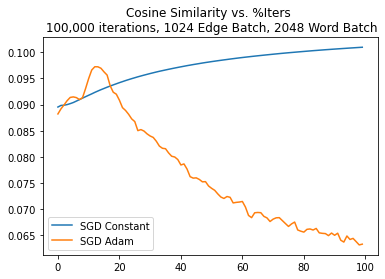

In [228]:
import matplotlib.pyplot as plt
plt.plot(range(len(F)), F, label="SGD Constant")
plt.plot(range(len(aF)), aF, label="SGD Adam")
plt.title("Cosine Similarity vs. %Iters \n 100,000 iterations, 1024 Edge Batch, 2048 Word Batch")
plt.legend()

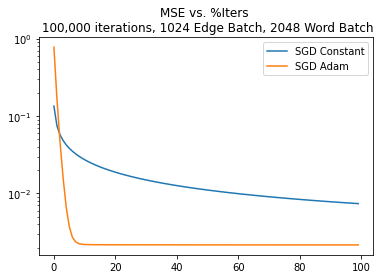

In [229]:
plt.semilogy(range(len(F2)), F2, label="SGD Constant")
plt.semilogy(range(len(aF2)), aF2, label="SGD Adam")
plt.title("MSE vs. %Iters \n 100,000 iterations, 1024 Edge Batch, 2048 Word Batch")
plt.legend()

In [151]:
r[:20]

DeviceArray([7.1032943e-08, 1.3062422e-07, 1.7305854e-27, 1.7696901e-07,
             2.3065836e-07, 1.5334923e-06, 2.8520965e-03, 9.4957936e-01,
             8.3257580e-01, 6.4646888e-01, 8.8769007e-01, 8.3618754e-01,
             8.8702232e-01, 7.3227888e-01, 5.9314322e-01, 2.4836677e-08,
             1.1635763e-09, 8.9975792e-01, 5.3561765e-01, 5.6239504e-01],            dtype=float32)

In [153]:
def invertIndexMap(m):
  m2 = {}
  for v1, v2 in m.items():
    m2[v2] = v1
  return m2

print(mapToTuples(wvIndex)[:10])
print(mapToTuples(invertIndexMap(wvIndex))[:10])

[('cant', 0), ('quite', 1), ('call', 2), ('misogyny', 3), ('patriarchal', 4), ('patronising', 5), ('pompous', 6), ('pomp', 7), ('pompou', 8), ('r', 9)]
[(0, 'cant'), (1, 'quite'), (2, 'call'), (3, 'misogyny'), (4, 'patriarchal'), (5, 'patronising'), (6, 'pompous'), (7, 'pomp'), (8, 'pompou'), (9, 'r')]


In [166]:
def weightsToWordWeightMap(indexToWord, weights):
  wordWeightMap = {}
  for idx, weight in enumerate(weights):
    wordWeightMap[indexToWord[idx]] = weight
  return wordWeightMap

In [230]:
indexToWord = invertIndexMap(wvIndex)
wordWeightMap = weightsToWordWeightMap(indexToWord, np.array(r))
wordWeightMapAdam = weightsToWordWeightMap(indexToWord, np.array(ar))

In [235]:
sortByVal(wordWeightMap)[:15]

[('laugh', 0.9802864),
 ('replace', 0.97996575),
 ('hide', 0.97991294),
 ('feeding', 0.97977316),
 ('goodness', 0.9795386),
 ('cry', 0.97935903),
 ('beating', 0.9786494),
 ('meaning', 0.97863996),
 ('sponsors', 0.97840333),
 ('apt', 0.9783374),
 ('speedy', 0.9780893),
 ('barely', 0.9779822),
 ('math', 0.9779201),
 ('disabled', 0.97778326),
 ('ashamed', 0.97768736)]

In [178]:
sortByVal(wordWeightMap)[::-1][:10]

[('de', 2.0657565e-37),
 ('faites', 2.7457878e-33),
 ('minutes', 1.0961616e-32),
 ('hi', 2.888489e-30),
 ('trading', 8.569569e-28),
 ('call', 1.7305854e-27),
 ('house', 5.1235948e-24),
 ('breaking', 2.3990961e-23),
 ('echauffementn', 8.1240233e-22),
 ('us', 3.858e-19)]

In [234]:
sortByVal(wordWeightMapAdam)[:15]

[('strict', 1.7358292),
 ('magnitude', 1.6299992),
 ('lying', 1.4925587),
 ('path', 1.4883835),
 ('soldiers', 1.4870441),
 ('iron', 1.3758439),
 ('iraq', 1.3636775),
 ('gods', 1.3189857),
 ('projects', 1.3185166),
 ('believes', 1.3124821),
 ('nofly', 1.3078176),
 ('failures', 1.3036107),
 ('planes', 1.2055637),
 ('lived', 1.2036895),
 ('stress', 1.1933296)]

In [232]:
sortByVal(wordWeightMapAdam)[::-1][:10]

[('breaking', -1.1801656e-36),
 ('de', 9.9299254e-36),
 ('minutes', 1.3858809e-35),
 ('faites', 2.5593522e-35),
 ('echauffementn', 2.727802e-35),
 ('amp', 3.1712522e-35),
 ('trading', 3.6816586e-35),
 ('us', 4.099229e-35),
 ('hi', 4.119968e-35),
 ('esg', 4.467532e-35)]